# Airline Delay Prediction
The task is about predicting airline delay. It's worth noticing that if a plane arrived earlier, we say that delay is zero (there ain't negative values). Another important assumption ==> if a flight was cancelled, delay is set on three days! Why? Because, it is extreme case when a flight was cancelled. If you're flying from time to time, you know what cancelled flight means in the middle of the trip. It is about helping manage this challenge.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import time
pd.set_option('display.max_rows', None)
import numpy as np
np.random.seed(1032019)
from collections import defaultdict
from ml_metrics import rmsle
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
import eli5
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
%matplotlib inline

# Train

In [2]:
train = pd.read_hdf('../input/train_airline_delay.h5')
print('Dataframe dimensions:', train.shape)
# gives some info on columns types and number of null values
table_info = pd.DataFrame(train.dtypes).T.rename(index={0: 'column type'})
table_info = table_info.append(pd.DataFrame(train.isnull().sum()).T.rename(
    index={0: 'null values (nb)'}))
table_info = table_info.append(pd.DataFrame(
    train.isnull().sum()/train.shape[0]*100).T.rename(
    index={0: 'null values (%)'}))
table_info

Dataframe dimensions: (1077114, 28)


,year,month,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,depature_delay,carrier_id,flight_number,tail_number,actual_elapsed_time,scheduled_elapsed_time,origin,destination,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay
column type,int8,int8,float32,int8,int8,float32,float32,float32,float16,float16,float16,int8,int16,int16,float16,float16,object,object,int64,bool,int8,float16,float16,float16,float16,float16,bool,float64
null values (nb),0,0,20858,0,0,0,20919,0,20919,20919,20858,0,0,0,20919,26,0,0,0,0,0,272959,272959,272959,272959,272959,0,0
null values (%),0,0,1.93647,0,0,0,1.94213,0,1.94213,1.94213,1.93647,0,0,0,1.94213,0.00241386,0,0,0,0,0,25.3417,25.3417,25.3417,25.3417,25.3417,0,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077114 entries, 0 to 1077113
Data columns (total 28 columns):
year                        1077114 non-null int8
month                       1077114 non-null int8
actual_departure_time       1056256 non-null float32
day_of_month                1077114 non-null int8
day_of_week                 1077114 non-null int8
scheduled_departure_time    1077114 non-null float32
actual_arrival_time         1056195 non-null float32
scheduled_arrival_time      1077114 non-null float32
air_time                    1056195 non-null float16
arrival_delay               1056195 non-null float16
depature_delay              1056256 non-null float16
carrier_id                  1077114 non-null int8
flight_number               1077114 non-null int16
tail_number                 1077114 non-null int16
actual_elapsed_time         1056195 non-null float16
scheduled_elapsed_time      1077088 non-null float16
origin                      1077114 non-null object
destin

# Test

In [4]:
test = pd.read_csv('../input/test_airline_delay.csv')
print('Dataframe dimensions:', test.shape)
# gives some info on columns types and number of null values
test_info = pd.DataFrame(test.dtypes).T.rename(index={0: 'column type'})
test_info = test_info.append(pd.DataFrame(test.isnull().sum()).T.rename(
    index={0: 'null values (nb)'}))
test_info = test_info.append(pd.DataFrame(
    test.isnull().sum()/test.shape[0]*100).T.rename(
    index={0: 'null values (%)'}))
test_info

Dataframe dimensions: (1078310, 15)


,id,year,month,day_of_month,day_of_week,scheduled_departure_time,scheduled_arrival_time,carrier_id,flight_number,tail_number,scheduled_elapsed_time,origin,destination,distance,target_delay
column type,int64,int64,int64,int64,int64,float64,float64,int64,int64,int64,float64,object,object,int64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,30,0,0,0,1078310
null values (%),0,0,0,0,0,0,0,0,0,0,0.00278213,0,0,0,100


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078310 entries, 0 to 1078309
Data columns (total 15 columns):
id                          1078310 non-null int64
year                        1078310 non-null int64
month                       1078310 non-null int64
day_of_month                1078310 non-null int64
day_of_week                 1078310 non-null int64
scheduled_departure_time    1078310 non-null float64
scheduled_arrival_time      1078310 non-null float64
carrier_id                  1078310 non-null int64
flight_number               1078310 non-null int64
tail_number                 1078310 non-null int64
scheduled_elapsed_time      1078280 non-null float64
origin                      1078310 non-null object
destination                 1078310 non-null object
distance                    1078310 non-null int64
target_delay                0 non-null float64
dtypes: float64(4), int64(9), object(2)
memory usage: 123.4+ MB


# Basic Model

In [6]:
feats = ['scheduled_arrival_time']
X = train[feats].values
y = train['target_delay'].values

model = DummyRegressor(strategy='median')
model.fit(X, y)
y_pred = model.predict(X)

rmsle(y, y_pred)

2.348499824040506

I've started with the raw data, and got 2.3485 [RMSLE](https://www.slideshare.net/KhorSoonHin/rmsle-cost-function). Why **RMSLE**? Because if model predicts bigger delay i.e. 20min, but in reality it's 15min, it's a mistake but not that dangerous. It's far worse the other way round. I want to punish model when it under estimates delay.

# Exploratory Analysis

<Figure size 1080x360 with 0 Axes>

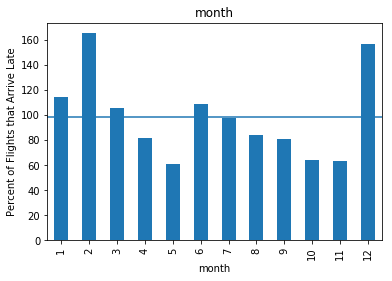

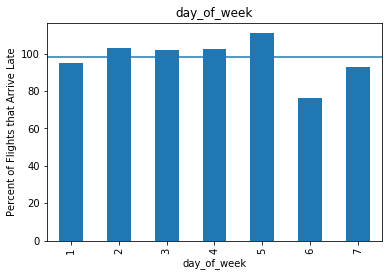

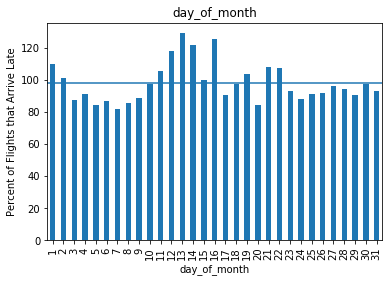

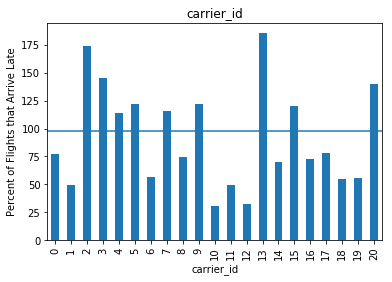

In [7]:
###############################################################################
# Proportion of late flights per category based on all other flights
###############################################################################
avgLate = np.sum(train['target_delay'])/len(train['target_delay'])
attributes = ['month', 'day_of_week', 'day_of_month', 'carrier_id']
for i, pred in enumerate(attributes):
    plt.figure(i, figsize=(15, 5))
    group = train.groupby(
        [pred], as_index=False).aggregate(np.mean)[[pred, 'target_delay']]
    group.sort_values(by=pred, inplace=True)
    group.plot.bar(x=pred, y='target_delay')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('Percent of Flights that Arrive Late')
    plt.title(pred)
    plt.legend().remove()

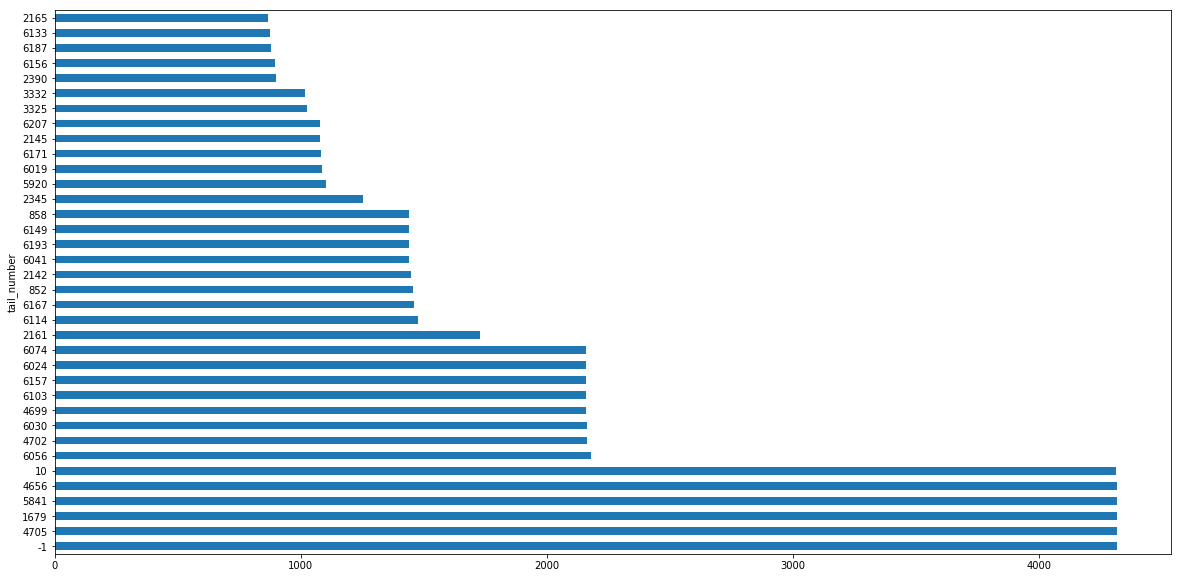

In [8]:
###############################################################################
# Mean of target_delay per tail_number. Top 36 results
###############################################################################
plt.figure(figsize=(20, 10))
train.sample(frac=0.1).groupby(
    ['tail_number']).agg(
    np.mean)['target_delay'].sort_values(
    ascending=False).head(36).plot(kind='barh');

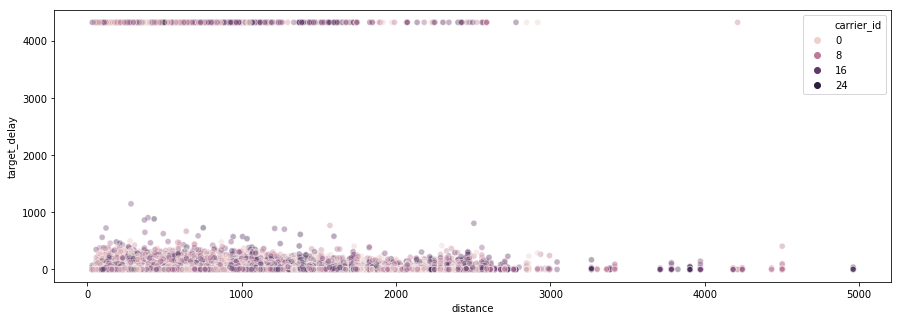

In [9]:
plt.figure(figsize=(15, 5))
sample_train = train.sample(frac=0.1)
sns.scatterplot(
    x='distance', y='target_delay', hue='carrier_id',
    data=sample_train, alpha=0.4);

    Reliance between distance and target_delay, carrier_id as color. Darker points more often travel long distance. Most of the planes fly around 2000 miles. We can see a bar above 4000, that's because when flight was cancelled, target_delay is infinity. To make it measurable there was assumption that target_delay is longer. I assume the bigger delay is the bigger impact it has on prediction, I will focus on that later. 

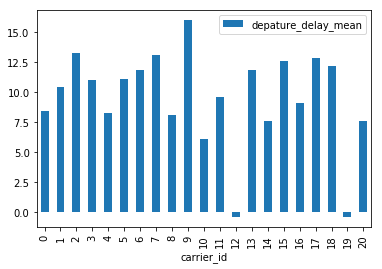

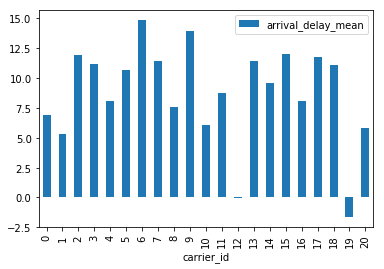

In [10]:
depature_delay = pd.DataFrame(
    {'depature_delay_mean': train.groupby(
        ['carrier_id'])['depature_delay'].mean()})
depature_delay.plot(kind='bar');


arrival_delay = pd.DataFrame(
    {'arrival_delay_mean': train.groupby(
        ['carrier_id'])['arrival_delay'].mean()})
arrival_delay.plot(kind='bar');

    How departure and arrival delay depends on carrier. What's intresting i.e. 12 or 19 are never late, even departs earlier. On the other hand 9 always departs late and then probably hurry like crazy, by the way it's better to avoid such carrier.

In [11]:
df_all = pd.concat([train, test], sort=False)

In [12]:
###############################################################################
#  Categorize Features
###############################################################################
cat_feats = df_all.select_dtypes(include=[np.object]).columns
for cat_feat in cat_feats:
    df_all['{0}_cat'.format(cat_feat)] = pd.factorize(df_all[cat_feat])[0]

# Feature Engineering
After reading some papers related to flight delays I've thought about it and designed few aggregated features.

In [13]:
###############################################################################
# Feature Engineering
###############################################################################
df_all['datetime'] = (2000 + df_all['year'].astype(
    int)) * 365 + df_all['month'].astype(int) * 30
df_all['datetime_full'] = df_all['datetime'].astype(
    int) + df_all['day_of_month'].astype(int)
df_all['tail_number_cat'] = df_all['tail_number'].factorize()[0]
df_all['tail_dist'] = df_all['tail_number_cat'] * df_all['distance']
df_all['delta_scheduled'] = df_all['scheduled_arrival_time'] - df_all[
    'scheduled_departure_time']
df_all['is_holiday'] = df_all['month'].map(lambda x: int(x in (7, 8)))
df_all['is_winter'] = df_all['month'].map(lambda x: int(x in (12, 1, 2)))

In [14]:
df_train = df_all[~df_all.target_delay.isnull()].copy()
df_test = df_all[df_all.target_delay.isnull()].copy()

In [15]:
###############################################################################
# is_cancelled_pred prediction
###############################################################################
clf_feats = ['year', 'month', 'day_of_month', 'day_of_week',
             'scheduled_departure_time', 'scheduled_arrival_time',
             'carrier_id', 'flight_number', 'tail_number',
             'scheduled_elapsed_time', 'origin_cat', 'destination_cat',
             'distance']
X_clf = df_train[clf_feats].values
y_clf = df_train['is_cancelled'].astype('int8').values

In [16]:
xgb_clf_params = {'max_depth': 5, 'n_estimators': 20, 'learning_rate': 0.40,
                  'n_jobs': 8, 'random_state': 2732019}

In [17]:
###############################################################################
# Train
###############################################################################
is_cancelled_pred = {}
cv = StratifiedKFold(n_splits=3, random_state=2732019)
for train_idx, test_idx in cv.split(X_clf, y_clf):
    X_clf_train, y_clf_train = X_clf[train_idx], y_clf[train_idx]
    X_clf_test, y_clf_test = X_clf[test_idx], y_clf[test_idx]

    model_clf = xgb.XGBClassifier(**xgb_clf_params)
    model_clf.fit(X_clf_train, y_clf_train)
    y_pred = model_clf.predict_proba(X_clf_test)[:, 1]

    is_cancelled_pred.update(dict(zip(list(test_idx), list(y_pred))))

df_train['is_cancelled_pred'] = df_train.index.map(is_cancelled_pred)

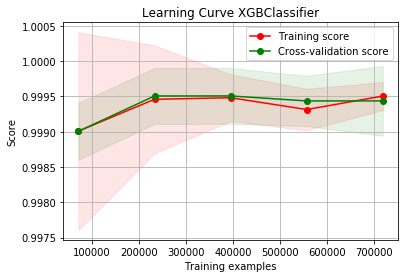

In [18]:
skplt.estimators.plot_learning_curve(
    model_clf, X_clf, y_clf, title='Learning Curve XGBClassifier', cv=3, scoring='precision');

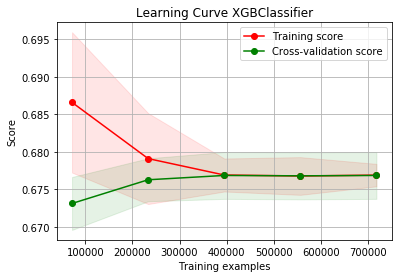

In [19]:
skplt.estimators.plot_learning_curve(
    model_clf, X_clf, y_clf, title='Learning Curve XGBClassifier', cv=3, scoring='recall');

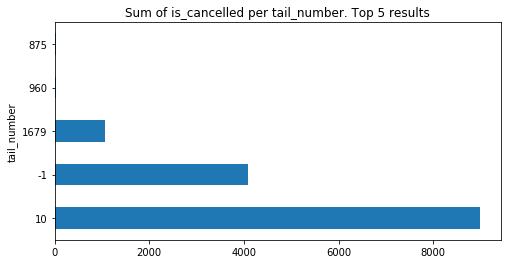

In [20]:
###############################################################################
# Sum of is_cancelled per tail_number. Top 5 results
###############################################################################
plt.figure(figsize=(8, 4))
train[train['is_cancelled'] == 1].groupby(
    ['tail_number']).agg(np.sum)['is_cancelled'].sort_values(
    ascending=False).head(5).plot(kind='barh')
plt.title('Sum of is_cancelled per tail_number. Top 5 results');

In [21]:
###############################################################################
# Test
###############################################################################
X_clf_train, y_clf_train = df_train[clf_feats].values, df_train['is_cancelled'].values
X_clf_test = df_test[clf_feats].values

model = xgb.XGBClassifier(**xgb_clf_params)
model.fit(X_clf_train, y_clf_train)
df_test['is_cancelled_pred'] = model.predict_proba(X_clf_test)[:, 1]

# Feature Selection

In [22]:
feats = test.select_dtypes(include=[np.number, np.bool]).columns
black_list = ['id', 'air_time', 'cancellation_code', 'actual_departure_time',
              'security_delay', 'arrival_delay', 'actual_arrival_time',
              'carrier_delay', 'actual_elapsed_time', 'target_delay',
              'late_aircraft_delay', 'depature_delay', 'weather_delay',
              'nas_delay']
feats = [feat for feat in feats if feat not in black_list]
feats += ['is_cancelled_pred', 'origin_cat', 'destination_cat',
          'datetime_full', 'delta_scheduled', 'is_holiday', 'is_winter',
          'tail_dist']

X_train = df_train[feats].values
y_train = df_train['target_delay'].values
y_train_log = np.log1p(y_train)

cv = KFold(n_splits=2, random_state=2732019, shuffle=False)

In [23]:
print("Selected features: ", feats)

Selected features:  ['year', 'month', 'day_of_month', 'day_of_week', 'scheduled_departure_time', 'scheduled_arrival_time', 'carrier_id', 'flight_number', 'tail_number', 'scheduled_elapsed_time', 'distance', 'is_cancelled_pred', 'origin_cat', 'destination_cat', 'datetime_full', 'delta_scheduled', 'is_holiday', 'is_winter', 'tail_dist']


In [24]:
model = xgb.XGBRegressor(**xgb_clf_params)

scores = {
    'xgb_RMSLE': []
}


def perform_scoring(m, y_true, y_log_pred):
    y_pred = np.expm1(y_log_pred)

    score = rmsle(y_train[test_idx], y_pred)
    print(m + " RMSLE: ", score)
    scores[m + '_RMSLE'].append(score)


fold = 0
for train_idx, test_idx in cv.split(X_train):
    fold += 1
    print("fold: ", fold)

    # XGB
    model.fit(X_train[train_idx], y_train_log[train_idx])
    y_log_pred = model.predict(X_train[test_idx])
    perform_scoring('xgb', y_train_log[test_idx], y_log_pred)


for s in scores:
    print(s, np.mean(scores[s]), np.std(scores[s]))

fold:  1
xgb RMSLE:  1.6093067828215146
fold:  2
xgb RMSLE:  1.6093760699385877
xgb_RMSLE 1.6093414263800512 3.464355853655121e-05


In [25]:
def my_rmsle(model, X_train, y_train_log):
    y_pred = model.predict(X_train)
    return rmsle(y_train_log, y_pred)

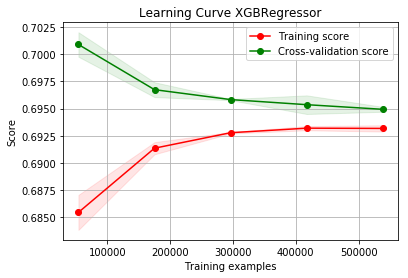

In [26]:
skplt.estimators.plot_learning_curve(
    model, X_train, y_train_log, cv=2, scoring=my_rmsle, title='Learning Curve XGBRegressor');

# Submission preparation

In [27]:
model.fit(X_train, y_train_log)
X_test = df_test[feats].values
y_test_pred_log = model.predict(X_test)
y_pred = np.expm1(y_test_pred_log)
df_test['id'] = df_test['id'].astype('int')
df_test['target_delay'] = y_pred
df_test[['id', 'target_delay']].to_csv(
    '../output/' + time.strftime("%Y%m%d_%H%M%S") + '.csv', index=False)

# Feature importances

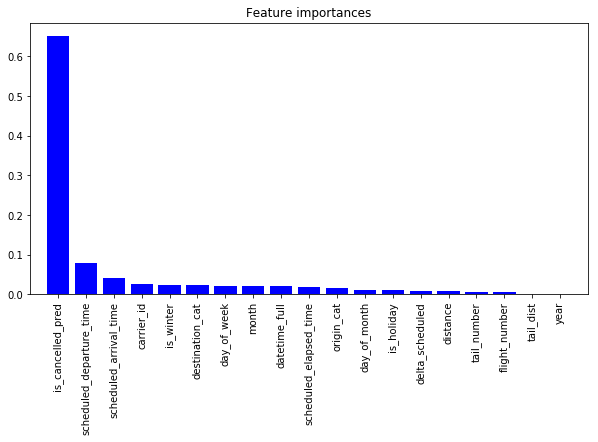

In [28]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X_train.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

draw_feature_importances(model, feats)

# eli5 XGBRegressor gain

In [29]:
model = xgb.XGBRegressor(**xgb_clf_params)
model.fit(X_train, y_train)
eli5.show_weights(model.get_booster(), feature_names=feats, top=50)

Weight,Feature
0.9360,is_cancelled_pred
0.0080,is_winter
0.0047,destination_cat
0.0044,datetime_full
0.0041,day_of_month
0.0040,tail_number
0.0039,flight_number
0.0037,distance
0.0037,origin_cat
0.0036,scheduled_arrival_time


# cover

In [30]:
eli5.explain_weights_xgboost(
    model.get_booster(), feature_names=feats, top=50, importance_type='cover')

Weight,Feature
0.1361,is_winter
0.1150,month
0.0971,distance
0.0958,datetime_full
0.0896,is_cancelled_pred
0.0886,carrier_id
0.0799,destination_cat
0.0559,origin_cat
0.0549,scheduled_elapsed_time
0.0487,delta_scheduled


# weight

In [31]:
eli5.explain_weights_xgboost(
    model.get_booster(), feature_names=feats, top=50, importance_type='weight')

Weight,Feature
0.3110,is_cancelled_pred
0.1260,datetime_full
0.0610,day_of_month
0.0591,flight_number
0.0571,scheduled_elapsed_time
0.0551,origin_cat
0.0551,tail_number
0.0413,scheduled_arrival_time
0.0394,scheduled_departure_time
0.0374,distance


In [32]:
###############################################################################
# Tuned Model
###############################################################################
xgb_params = {
    'n_jobs': 4,
    'max_depth': 14,
    'n_estimators': 120,
    'learning_rate': 0.1,
    'min_child_weight': 8,
    'random_state': 2632019
}

In [33]:
model_tuned = xgb.XGBRegressor(**xgb_params)

scores = {
    'xgb_RMSLE': []
}


def perform_scoring(m, y_true, y_log_pred):
    y_pred = np.expm1(y_log_pred)

    score = rmsle(y_train[test_idx], y_pred)
    print(m + " RMSLE: ", score)
    scores[m + '_RMSLE'].append(score)


fold = 0
for train_idx, test_idx in cv.split(X_train):
    fold += 1
    print("fold: ", fold)

    # XGB
    model_tuned.fit(X_train[train_idx], y_train_log[train_idx])
    y_log_pred = model_tuned.predict(X_train[test_idx])
    perform_scoring('xgb', y_train_log[test_idx], y_log_pred)


for s in scores:
    print(s, np.mean(scores[s]), np.std(scores[s]))

fold:  1
xgb RMSLE:  1.5543549843681244
fold:  2
xgb RMSLE:  1.5532505639818577
xgb_RMSLE 1.553802774174991 0.0005522101931333401


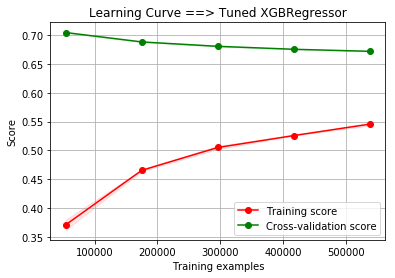

In [34]:
skplt.estimators.plot_learning_curve(
    model_tuned, X_train, y_train_log, cv=2, scoring=my_rmsle, title='Learning Curve ==> Tuned XGBRegressor');

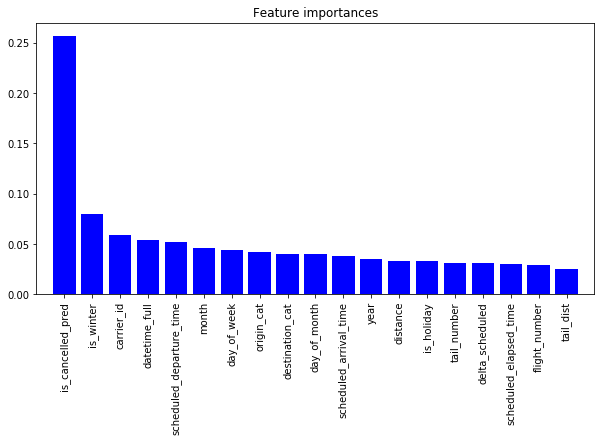

In [35]:
draw_feature_importances(model_tuned, feats)